<a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-sampling-modeling?scriptVersionId=159140683" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<hr>
    <h1 style='font-family:verdana;text-align:center'>🏦Loan Defaulter Credit Risk Analytics - Non-Sampling, Sampling techniques and penalizing algorithms</h1>
<hr>
<p> 
    If you'd like to check out the EDA and preprocessing notebook, 
    <a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-analytics-eda-preprocessing">please click here.</a><br>
    
The objective of this kernel is to experiment without sampling, then applying sampling techniques and then implement cost sensitive learning. I have referred to the following blogs to try out different methods:<br>
    <ul>
        <li>
            <a href="https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/">Blog 1</a> - This post covers choosing the right metrics, using imblearn for sampling, and implementing penalized learning algorithms.
        </li>
        <li>
            <a href="https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a">Blog 2</a> - Again, imblearn sampling techniques are included with a couple of extra algorithms, not covered in Blog 1. Additionally, there are visualizations to describe the working of the classifiers. 
        </li>
        <li>
            <a href="https://medium.com/@data.pilot/7-techniques-to-handle-class-imbalance-in-machine-learning-eb1297419ec9#:~:text=Ensemble%20techniques%20such%20as%20Bagging,to%20capture%20minority%20class%20patterns.">Blog 3</a> - Topics unique to this post are: Generating synthetic data using Autoencoders and One-class classification approaches using IsolationForest and One-Class SVM.
        </li>
        <li>
            <a href="https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/">Blog 4</a> - Discusses threshold moving for imbalanced classification. 
        </li>
        <li> 
            <a href="https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3">Blog 5</a> - Similar to Blog 4, elaborates on metrics and thresholding tuning.
        </li>
        <li>
            <a href="https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3">Blog 6 </a> - A continuation of Blogs 4 and 5
        </li>
        <li>
            <a href="https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/"> Blog 7a </a> and <br>
            <a href="https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/"> Blog 7b </a> - Using calibrated probabilities
        </li>
   </ul>
</p>

In [1]:
import numpy as np 
import pandas as pd
import copy
import optuna
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics, calibration

from imblearn import metrics as imb_metrics, under_sampling, over_sampling
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-defaulter/application_data.csv
/kaggle/input/loan-defaulter/previous_application.csv
/kaggle/input/loan-defaulter/columns_description.csv
/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv


In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 

In [2]:
application_df = pd.read_csv('/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv')

In [3]:
application_df = application_df.dropna() 

In [4]:
X = application_df.drop(['Unnamed: 0','TARGET'],axis=1)
Y = application_df.TARGET

In [5]:
Y.value_counts()

TARGET
0    227030
1     21686
Name: count, dtype: int64

<h4>Roughly 91% of the target belongs to class 0 while 9% of the data belongs to class 1</h4> 

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=1)

In [7]:
robust_scaler = preprocessing.RobustScaler()

In [8]:
X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Applicant_Age','Years_of_experience','Years_Registration','Years_Id_Publish','DAYS_LAST_PHONE_CHANGE']] = robust_scaler.fit_transform(X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Applicant_Age','Years_of_experience','Years_Registration','Years_Id_Publish','DAYS_LAST_PHONE_CHANGE']])

In [9]:
X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Applicant_Age','Years_of_experience','Years_Registration','Years_Id_Publish','DAYS_LAST_PHONE_CHANGE']] = robust_scaler.transform(X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','Applicant_Age','Years_of_experience','Years_Registration','Years_Id_Publish','DAYS_LAST_PHONE_CHANGE']])

/tmp/ipykernel_119/1262462063.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train)


<Axes: xlabel='TARGET', ylabel='Density'>

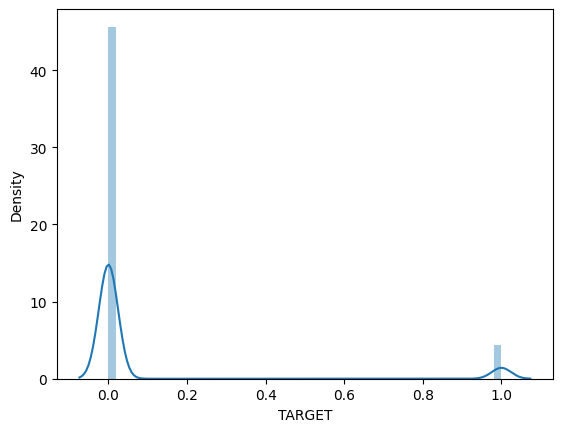

In [10]:
sns.distplot(Y_train)

/tmp/ipykernel_119/336957920.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_test)


<Axes: xlabel='TARGET', ylabel='Density'>

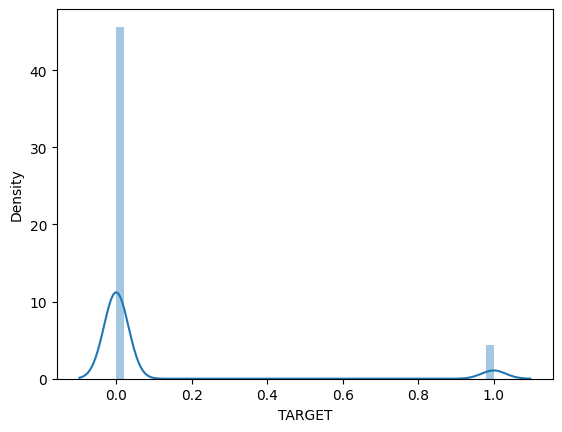

In [11]:
sns.distplot(Y_test)

<h4> Before implementing sampling methods, I will build models on the original data using the threshold moving.(Blog 4)</h4><br>
<p> We'll begin with logistic regression before trying ensemble algorithms like HistGradientBoosting or XGBoost.</p>

In [ ]:
from sklearn.linear_model import LogisticRegression

<h4><b> Choosing the right evaluation metric </b></h4>
<a href="https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/#:~:text=Precision-Recall%20Metrics&text=The%20F-Measure%20is%20a%20popular%20metric%20for%20imbalanced%20classification."> Link to the blog. </a> The image posted below serves as a guide to choosing the right evaluation metric for an imbalanced classification task.

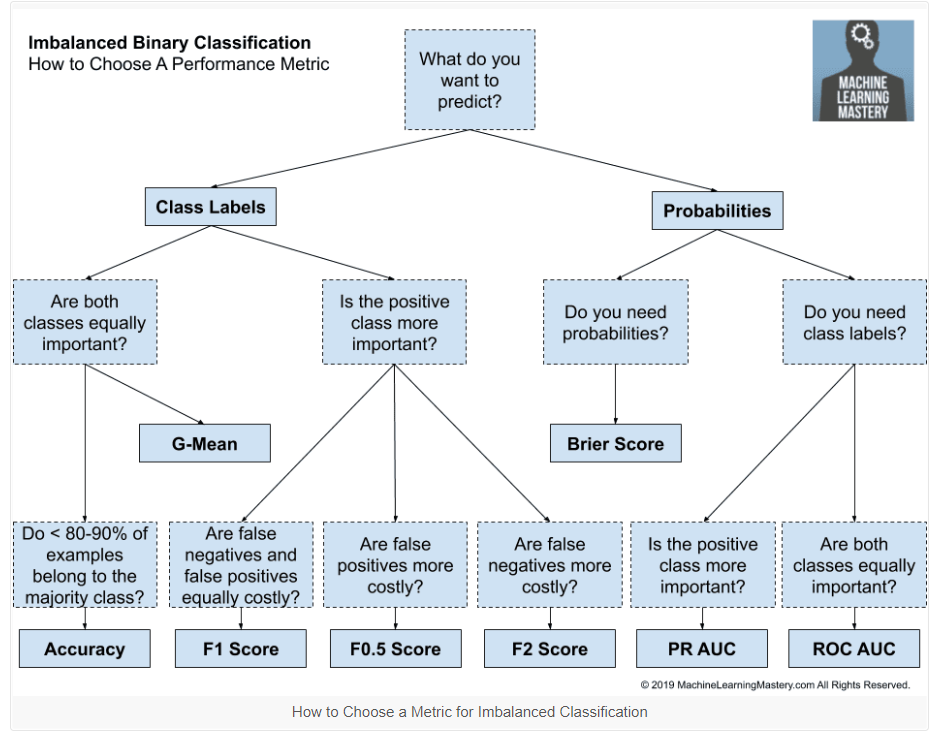

<h4> Using the above flowchart as reference, I will be using PR AUC and F2 score as metrics. </h4>

In [12]:
def display_confusion_matrix(Y_test:pd.DataFrame, Y_pred:pd.DataFrame)->None:
    plt.figure(figsize=(12,6))
    cm = metrics.confusion_matrix(Y_test,Y_pred,labels=[1,0])
    cm_display = metrics.ConfusionMatrixDisplay(cm,display_labels=[1,0])
    cm_display.plot()
    plt.show()

In [13]:
def plot_precision_recall_curve(Y_test:pd.DataFrame, Y_pred:pd.DataFrame, is_threshold_used=False, 
                   best_threshold_ix=None, precision_threshold=None, recall_threshold=None)->None:
    plt.figure(figsize=(12,4))
    no_skill = len(Y_test[Y_test==1]) / len(Y_test)
    plt.plot([0,1],[no_skill,no_skill],linestyle='--',label='No Skill')
    #plt.plot([1,0], [1,1], linestyle='--', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    if is_threshold_used:
        precision,recall = precision_threshold,recall_threshold
        plt.scatter(recall[best_threshold_ix],precision[best_threshold_ix],marker='o',color='black',label='Best')
    else:
        precision,recall,_ = metrics.precision_recall_curve(Y_test,Y_pred)

    auc_score = metrics.auc(recall,precision)
        
    plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score}')
    plt.legend()
    plt.show()

In [14]:
def evaluate_model(Y_test:pd.DataFrame, Y_pred_proba:pd.DataFrame, Y_pred_label:pd.DataFrame,
                   is_threshold_used=False)->None:
    print(imb_metrics.classification_report_imbalanced(Y_test,Y_pred_label))
    weighted_recall = metrics.recall_score(Y_test,Y_pred_label,average='weighted')
    print(f'Weighted Recall :{weighted_recall}')
    if not is_threshold_used:
        plot_precision_recall_curve(Y_test,Y_pred_proba)
    display_confusion_matrix(Y_test,Y_pred_label)

In [15]:
def build_model(classifier, X_train:pd.DataFrame, Y_train:pd.DataFrame, X_test: pd.DataFrame, 
                Y_test:pd.DataFrame)-> None:
    classifier.fit(X_train,Y_train)
    Y_pred_proba = classifier.predict_proba(X_test)[:,1]
    Y_pred_label = classifier.predict(X_test)
    return (classifier,Y_pred_proba,Y_pred_label)

In [ ]:
logit_clf_balanced = LogisticRegression(solver='newton-cholesky',class_weight='balanced')

In [ ]:
logit_clf_balanced,Y_pred_logit_proba,Y_pred_logit_label = build_model(logit_clf_balanced,X_train,Y_train,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_proba,Y_pred_logit_label)

<h4> Tuning the classifier </h4>

In [ ]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        #'penalty':trial.suggest_categorical('penalty',['l1','l2','elasticnet','none']),
        'C':trial.suggest_float('C',0.001,2),
        'tol':trial.suggest_float('tol' , 1e-6 , 1e-2),
        'class_weight':'balanced',
        'n_jobs':-1
    }
    logit_clf_tuned = LogisticRegression(**param).fit(X_train,Y_train)
    Y_pred_tuned = logit_clf_tuned.predict(X_test)
    f2_score = metrics.fbeta_score(Y_test, Y_pred_tuned, beta=2)
    return f2_score 

In [ ]:
study = optuna.create_study(direction = 'maximize')

In [ ]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)

In [ ]:
print('Logistic Regression Best Parameters:',study.best_trial.params)
print('Best F2 score:',study.best_value)

In [ ]:
best_params_logit = study.best_trial.params
best_params_logit['solver'] = 'newton-cholesky'
best_params_logit['class_weight'] = 'balanced'
#optimal_c = study.best_trial.params['C']
#optimal_tol = study.best_trial.params['tol']

In [ ]:
logit_clf_tuned = LogisticRegression(**best_params_logit)

In [ ]:
logit_clf_tuned,Y_pred_logit_proba_tuned,Y_pred_logit_label_tuned = build_model(logit_clf_tuned,X_train,Y_train,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_proba_tuned,Y_pred_logit_label_tuned)

<h1> Third Approach - Computing optimal class weights</h1>
<p>  Before sampling, we can predict class probabilities instead of class labels and compute the weights of individual classes by thresholding. <b>The goal is to experiment with different thresholds and assign labels according to the best threshold.</b><br>
    For example, let's assume that the threshold = 0.5.<br> 
    Any probability less than 0.5 would be assigned to class 0 and greater than 0.5 would be class 1. Instead of setting 0.5 as the threshold, we will try different values to see how threshold will return the optimal F1 score.<br><br>
    Additionally, Geometric Mean and  Youden’s J statistic have been used to identify the best threshold value for an ROC curve.<br><br>

Here's a sneak peek into how G-Mean and J Statistic are computed:<br>
> G-Mean = sqrt(Sensitivity * Specificity), where:<br>
>> Sensitivity = True Positives / (True Positives + False Negatives) = True Positive Rate<br>
>> Specificity = True Negatives / (False Positives + True Negatives) = 1 - False Positive Rate<br>
    
> J Statistic = Sensitivity + Specificity – 1, (OR), True Positive Rate - False Positive Rate

For more information, please refer Blogs 4 and 5 with other resources.
</p>

<h3> Optimum threshold for Precision-Recall curve - Steps to follow: </h3>
<p> 
    <ol>
        <li> Split the original dataset into train and test sets. </li>
        <li> Build a classifier and predict probabilities. </li>
        <li> For each threshold, using the Precision-Recall curve, compute AUC. </li>
        <li> Identify the threshold for which AUC score is highest. </li>
    </ol>
</p>

In [16]:
def convert_probs_to_labels(threshold,class_prob):
    return (class_prob>=threshold).astype('int') 

In [17]:
def get_valid_thresholding_metrics(precision,recall):
    f2score = (5*precision*recall)/(4*precision+recall)
    nan_indices = np.argwhere(np.isnan(f2score))
    nan_indices = nan_indices.flatten()
    precision = np.delete(precision,nan_indices)
    recall = np.delete(recall,nan_indices)
    f2score = np.delete(f2score,nan_indices)
    
    return (precision,recall,f2score)

In [18]:
def get_thresholding_metrics(classifier,predicted_probs):
    #Y_pred_tuned_probs = classifier.predict_proba(X_test)
    #predicted_probs = Y_pred_tuned_probs[:,1]
    precision,recall,thresholds = metrics.precision_recall_curve(Y_test,predicted_probs)
    precision,recall,f2score = get_valid_thresholding_metrics(precision,recall)
    
    return (precision,recall,f2score,thresholds)

In [ ]:
precision,recall,f2_score,thresholds = get_thresholding_metrics(logit_clf_tuned,Y_pred_logit_proba_tuned)

In [ ]:
ix = np.argmax(f2_score)
best_threshold = thresholds[ix]
best_f2_score = f2_score[ix]
print('Best Threshold=%f, F2-Score=%.3f' % (best_threshold, best_f2_score))

In [ ]:
Y_pred_optimal_labels_logit = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_logit_proba_tuned))

In [ ]:
evaluate_model(Y_test,Y_pred_logit_proba_tuned,Y_pred_optimal_labels_logit,True)

In [ ]:
plot_precision_recall_curve(Y_test,Y_pred_logit_proba_tuned,True,ix,precision,recall)

<h3> Optimum threshold - Direct calculation </h3>

In [19]:
def compute_optimal_threshold(predicted_probs):
    best_f2_score = -np.inf
    best_threshold = -np.inf
    for threshold in np.arange(0,1,0.001):
        Y_pred_threshold = convert_probs_to_labels(threshold,predicted_probs)
        f2_score = metrics.fbeta_score(Y_test,Y_pred_threshold,beta=2)
        if f2_score > best_f2_score:
            best_f2_score = f2_score 
            best_threshold = threshold    
    
    return (best_f2_score, best_threshold)

In [ ]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_logit_proba_tuned)

In [ ]:
best_threshold,best_f2_score

In [ ]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_logit_proba_tuned))

In [ ]:
evaluate_model(Y_test,Y_pred_logit_proba_tuned,Y_pred_best_threshold)

<p>
    <h1> Logistic Regression observations:</h1><br>
    <ul>
        <li> Totally, there were 4 attempts to build, evaluate and improve the model. </li>
        <li> Both the tuned classifier and ROC threshold models were superior to the base model.</li>
        <li> Although the AUC score for the direct threshold approach is not as high as the ROC thresholding method, there is a marked difference in identifying false positives. Yet, for this problem statement, it is essential to correctly identify false negatives, as a potential loan defaulting applicant should be more accurately flagged by the model.</li>
    </ul>
    <b>Now, let's build ensemble models like HistGradientBoostingClassifier and XGBoost.</b>
</p>
        

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [21]:
hgb_clf = HistGradientBoostingClassifier(class_weight='balanced')

In [22]:
hgb_clf,Y_pred_hgb_proba,Y_pred_hgb_labels = build_model(hgb_clf,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.62      0.79      0.64      0.42     45407
          1       0.15      0.62      0.67      0.24      0.64      0.41      4337

avg / total       0.88      0.67      0.62      0.74      0.64      0.42     49744

Weighted Recall :0.6669749115471213


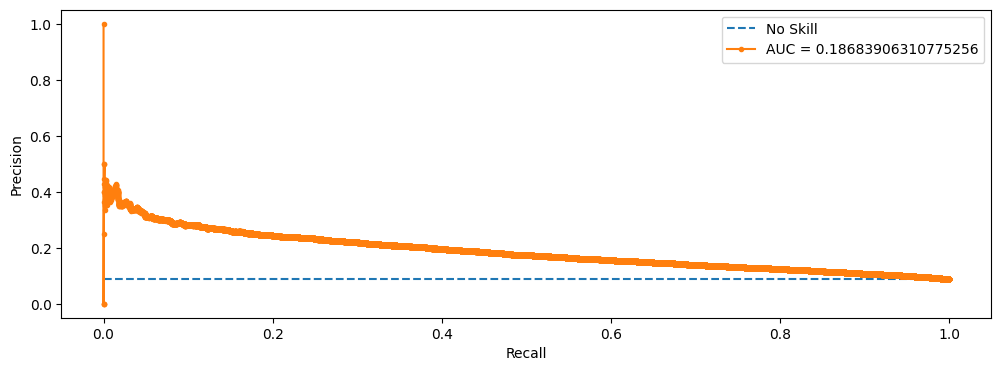

<Figure size 1200x600 with 0 Axes>

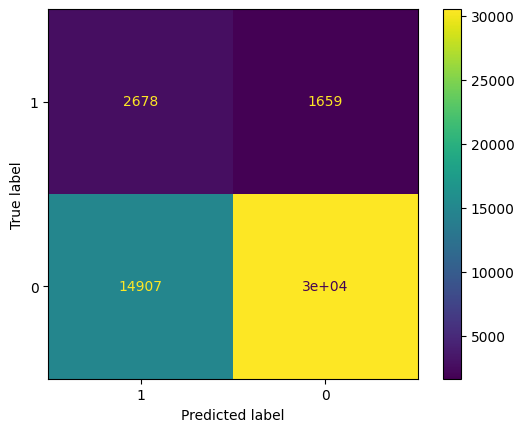

In [23]:
evaluate_model(Y_test,Y_pred_hgb_proba,Y_pred_hgb_labels)

<h3> Tuning the HistGradientBoosting classifier </h3>

In [ ]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        'learning_rate':trial.suggest_float('learning_rate',1e-3,1),
        'max_iter':trial.suggest_int('max_iter',100,500),
        'max_depth':trial.suggest_int('max_depth',10,1000),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',10,50),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',10,100),
        'class_weight':'balanced'
    }
    hgb_clf_tuned = HistGradientBoostingClassifier(**param).fit(X_train,Y_train)
    Y_pred_tuned = hgb_clf_tuned.predict_proba(X_test)[:,1]
    precision,recall,_ = metrics.precision_recall_curve(Y_test,Y_pred_tuned)
    auc_score = metrics.auc(recall,precision)
    return auc_score 

In [ ]:
study = optuna.create_study(direction = 'maximize')

In [ ]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)

In [ ]:
print('Hist GB Best Parameters:',study.best_trial.params)
print('Best AUC score:',study.best_value)

#best_params_hgb = study.best_trial.params
best_params_hgb = {'learning_rate': 0.0550952982537752, 'max_iter': 259, 'max_depth': 866, 'max_leaf_nodes': 30, 'min_samples_leaf': 67}

Best AUC score: 0.19049094053488047

In [24]:
#best_params_hgb = study.best_trial.params
best_params_hgb = {'learning_rate': 0.0550952982537752, 'max_iter': 259, 'max_depth': 866, 'max_leaf_nodes': 30, 'min_samples_leaf': 67}

In [25]:
best_params_hgb['class_weight']='balanced'

In [26]:
hgb_clf_tuned = HistGradientBoostingClassifier(**best_params_hgb)

In [27]:
hgb_clf_tuned,Y_pred_hgb_tuned_proba,Y_pred_hgb_tuned_labels = build_model(hgb_clf_tuned,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.62      0.78      0.64      0.42     45407
          1       0.15      0.62      0.67      0.24      0.64      0.41      4337

avg / total       0.88      0.67      0.62      0.74      0.64      0.42     49744

Weighted Recall :0.6650651334834352


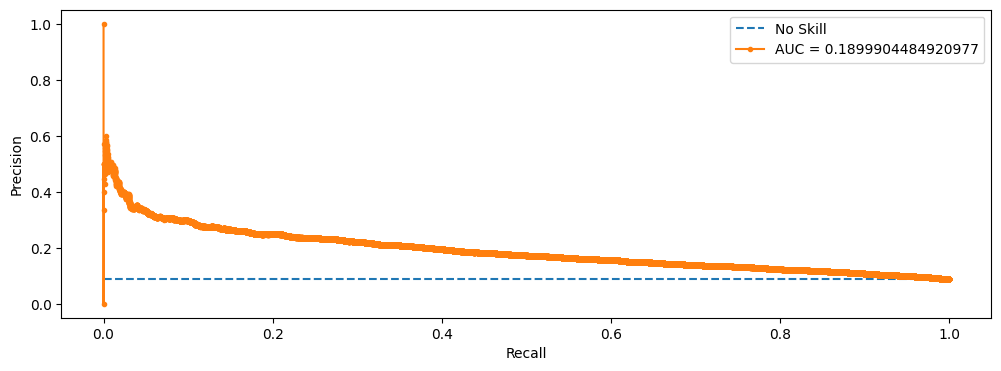

<Figure size 1200x600 with 0 Axes>

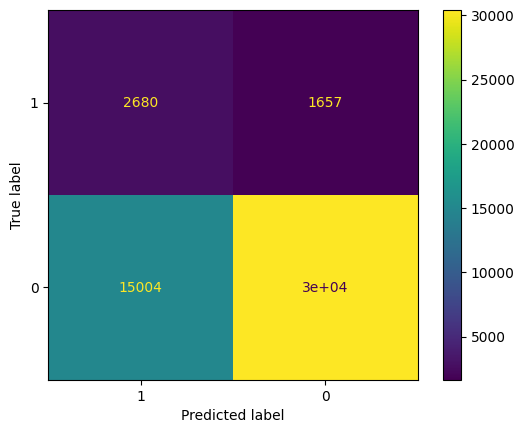

In [28]:
evaluate_model(Y_test,Y_pred_hgb_tuned_proba,Y_pred_hgb_tuned_labels)

<h4> Repeating the thresholding moving process </h4>

<h4> Starting with the optimal ROC threshold computation</h4>

In [29]:
precision_hgb,recall_hgb,f2_score_hgb,thresholds_hgb = get_thresholding_metrics(hgb_clf_tuned,Y_pred_hgb_tuned_proba)

/tmp/ipykernel_119/2487673585.py:2: RuntimeWarning: invalid value encountered in divide
  f2score = (5*precision*recall)/(4*precision+recall)


In [30]:
ix = np.argmax(f2_score_hgb)
best_threshold = thresholds_hgb[ix]
best_f2_score = f2_score_hgb[ix]
print('Best Threshold=%f, F2-score=%.3f' % (best_threshold, best_f2_score))

Best Threshold=0.432394, F2-score=0.388


In [31]:
Y_pred_optimal_hgb = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_hgb_tuned_proba))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.53      0.75      0.68      0.63      0.39     45407
          1       0.13      0.75      0.53      0.22      0.63      0.41      4337

avg / total       0.89      0.55      0.73      0.64      0.63      0.39     49744

Weighted Recall :0.5481666130588613


<Figure size 1200x600 with 0 Axes>

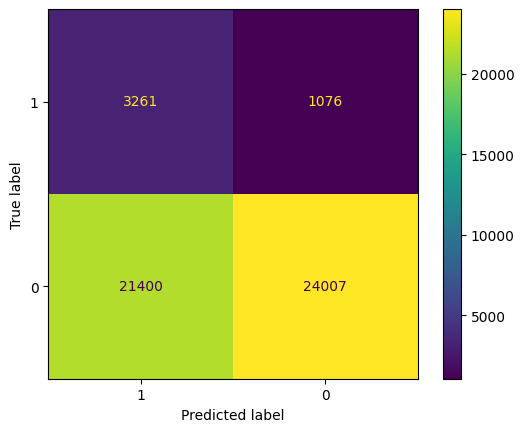

In [32]:
evaluate_model(Y_test,Y_pred_hgb_tuned_proba,Y_pred_optimal_hgb,True)

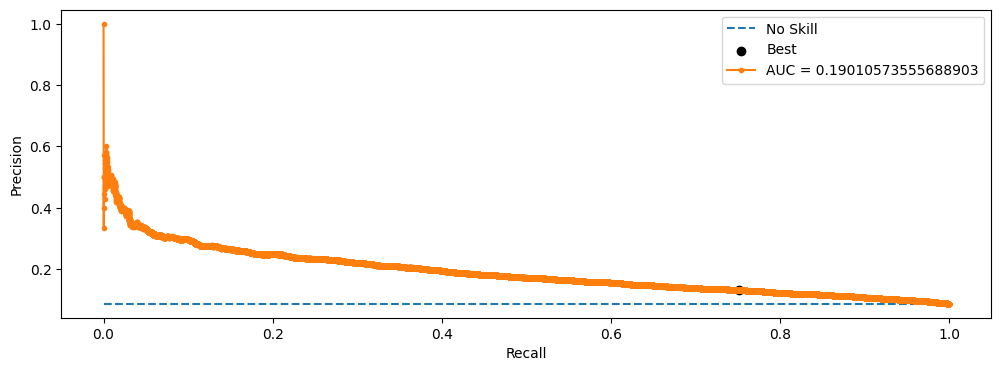

In [33]:
plot_precision_recall_curve(Y_test,Y_pred_hgb_tuned_proba,True,ix,precision_hgb,recall_hgb)

<h4> Threshold computation </h4>

In [34]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_hgb_tuned_proba)

In [35]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_hgb_tuned_proba))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.53      0.75      0.68      0.63      0.39     45407
          1       0.13      0.75      0.53      0.22      0.63      0.41      4337

avg / total       0.89      0.55      0.73      0.64      0.63      0.39     49744

Weighted Recall :0.5473624959794146


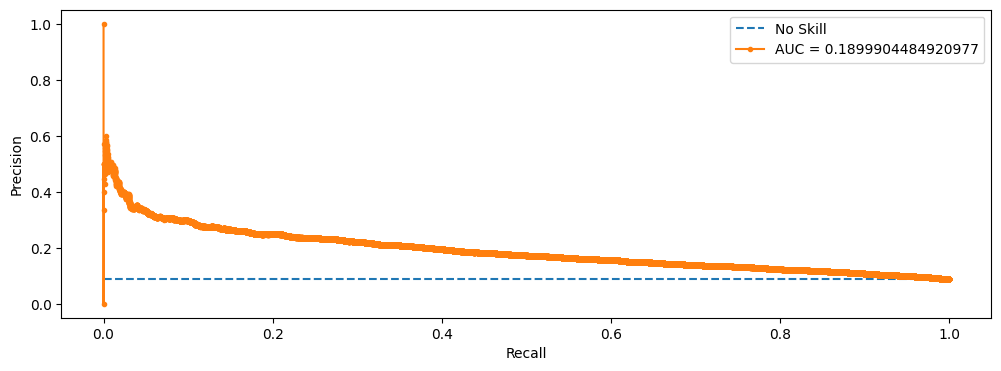

<Figure size 1200x600 with 0 Axes>

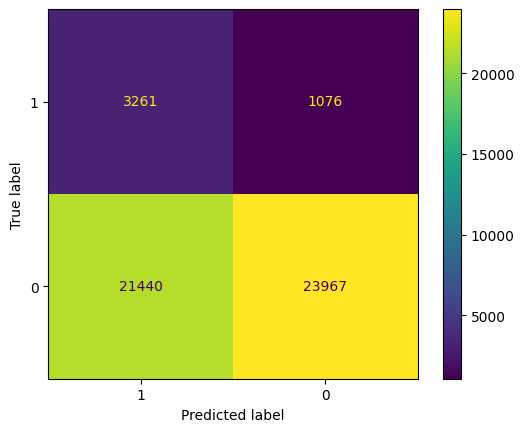

In [36]:
evaluate_model(Y_test,Y_pred_hgb_tuned_proba,Y_pred_best_threshold)

<h1> Approach 4 - Building a calibrated classifier using HistGradientBoosting </h1>

<h4> Plotting the reliability diagram </h4>

In [37]:
X_train_cccv, X_valid_cccv, Y_train_cccv, Y_valid_cccv = model_selection.train_test_split(X_train,Y_train,stratify=Y_train,test_size=0.33,random_state=1)

<h4> Method 1 - Prefitting the model </h4>

In [38]:
hgb_clf_cccv = HistGradientBoostingClassifier(**best_params_hgb).fit(X_train_cccv,Y_train_cccv)

In [39]:
Y_pred_proba_cccv = hgb_clf_cccv.predict_proba(X_valid_cccv)[:,1]

In [40]:
fop, mpv = calibration.calibration_curve(Y_valid_cccv,Y_pred_proba_cccv,normalize=False)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


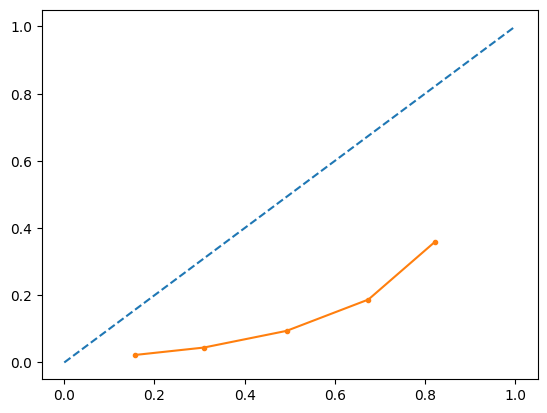

In [41]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

<h4> As we do not get an S-shaped curve, so we can set CalibratedClassifier method to 'isotonic' and try again. </h4>

In [42]:
hgb_clf_cccv = HistGradientBoostingClassifier(**best_params_hgb).fit(X_train_cccv,Y_train_cccv)

In [43]:
calibrated_hgb = calibration.CalibratedClassifierCV(hgb_clf_cccv, method='isotonic', cv='prefit')

In [44]:
calibrated_hgb.fit(X_valid_cccv,Y_valid_cccv)

CalibratedClassifierCV(cv='prefit',
                       estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                learning_rate=0.0550952982537752,
                                                                max_depth=866,
                                                                max_iter=259,
                                                                max_leaf_nodes=30,
                                                                min_samples_leaf=67),
                       method='isotonic')

In [45]:
Y_pred_calibrated_hgb = calibrated_hgb.predict(X_test)
Y_pred_probs_calibrated_hgb = calibrated_hgb.predict_proba(X_test)[:,1]

In [46]:
fop_calibrated, mpv_calibrated = calibration.calibration_curve(Y_test,Y_pred_probs_calibrated_hgb,normalize=False)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


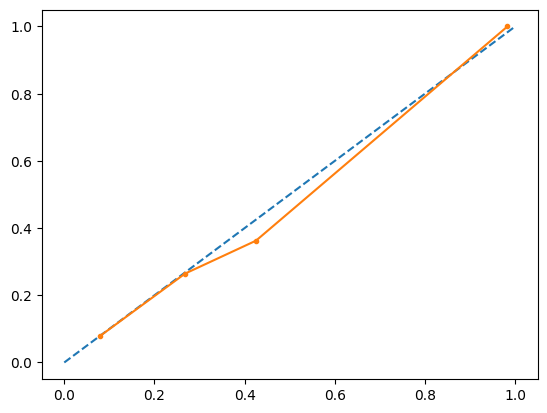

In [47]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')
plt.show()

<h4> From the above plot, it can be seen that the classifier has been calibrated to reflect more accurately, the true likelihood of the class.</h4>

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.00      0.95      0.03      0.00     45407
          1       1.00      0.00      1.00      0.00      0.03      0.00      4337

avg / total       0.92      0.91      0.09      0.87      0.03      0.00     49744

Weighted Recall :0.9128739144419428


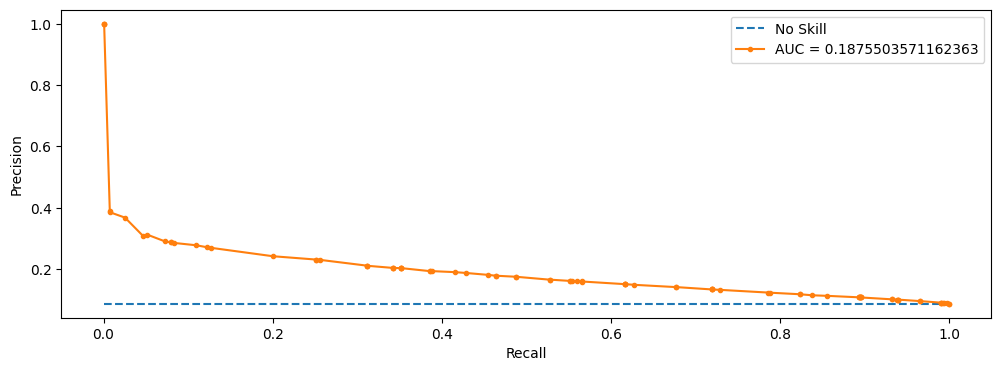

<Figure size 1200x600 with 0 Axes>

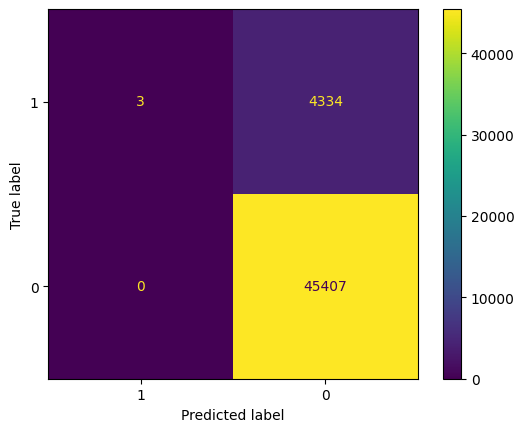

In [48]:
evaluate_model(Y_test,Y_pred_probs_calibrated_hgb,Y_pred_calibrated_hgb)

In [49]:
calibrated_hgb_score = metrics.brier_score_loss(Y_test,Y_pred_probs_calibrated_hgb)

In [50]:
calibrated_hgb_score

0.07598005160583506

<p>
    <h1> HistGradientBoosting observations:</h1><br>
    <ul>
        <li> Totally, there were 5 attempts to build, evaluate and improve the model. </li>
        <li> Both the tuned classifier and ROC threshold models were similar to the base model in terms of the confusion matrix. However, ROC threshold method had the highest AUC score of 0.75.</li>
        <li> The AUC score and false negatives for the direct threshold approach were inferior [Lower AUC and higher false negatives] to the ROC thresholding method, but like the logistic regression model, it was able to detect false positives better.</li>
        <li> Lastly, a calibrated classifier was built but did not perform as well as the other models. </li>
    </ul>
    <b>Proceeding to the XGBoost model.</b></p>
</p>
        

<h4> Building the XGBoost classifier </h4>

In [51]:
xgb_clf = XGBClassifier()

In [52]:
xgb_clf, Y_pred_xgb_proba, Y_pred_xgb_labels = build_model(xgb_clf,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.01      0.95      0.08      0.01     45407
          1       0.38      0.01      1.00      0.01      0.08      0.01      4337

avg / total       0.87      0.91      0.09      0.87      0.08      0.01     49744

Weighted Recall :0.9124517529752332


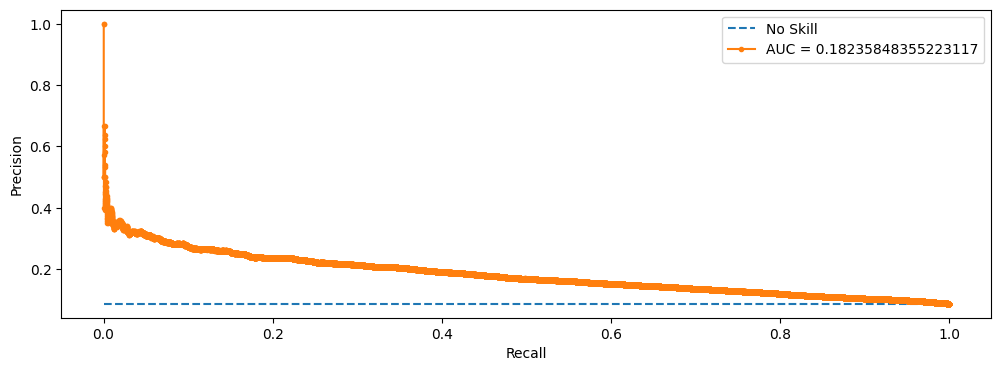

<Figure size 1200x600 with 0 Axes>

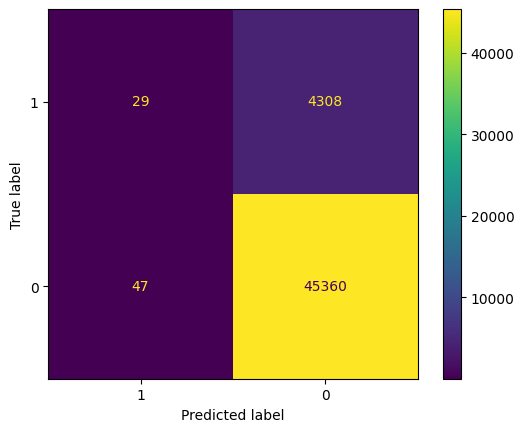

In [53]:
evaluate_model(Y_test,Y_pred_xgb_proba,Y_pred_xgb_labels)

<h4> Tuning the XGBoost classifier </h4>

In [62]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        'eta':trial.suggest_float('eta',1e-3,1),
        'lambda':trial.suggest_float('lambda',1e-3,1),
        'alpha':trial.suggest_float('alpha',1e-3,1),
        'max_depth':trial.suggest_int('max_depth',5,50),
        'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
    }
    xgb_clf_tuned = XGBClassifier(**param).fit(X_train,Y_train)
    Y_pred_tuned = xgb_clf_tuned.predict_proba(X_test)[:,1]
    precision,recall,_ = metrics.precision_recall_curve(Y_test,Y_pred_tuned)
    auc_score = metrics.auc(recall,precision)
    return auc_score 

In [63]:
study = optuna.create_study(direction = 'maximize')

[I 2024-01-16 04:31:09,569] A new study created in memory with name: no-name-a561f89f-b05c-434c-b317-96ca8ec41d75


In [64]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 50)

[I 2024-01-16 04:31:25,942] Trial 0 finished with value: 0.1281452532797992 and parameters: {'eta': 0.9117683889186363, 'lambda': 0.10935657963099098, 'alpha': 0.6129221415852328, 'max_depth': 46, 'booster': 'gbtree'}. Best is trial 0 with value: 0.1281452532797992.
[I 2024-01-16 04:31:39,924] Trial 1 finished with value: 0.13025261495480112 and parameters: {'eta': 0.9938351682994258, 'lambda': 0.33385327850124263, 'alpha': 0.6031454882606749, 'max_depth': 21, 'booster': 'gbtree'}. Best is trial 1 with value: 0.13025261495480112.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:31:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-01-16 04:31:46,021] Trial 2 finished with value: 0.5435931971695078 and parameters: {'eta': 0.8921113227971516, 'lambda': 0.4839399745373443, 'alpha': 0.8003584441467164, 'max_depth': 48, 'booster': 'gblinear'}. Best is trial 2 with value: 0.5435931971

In [65]:
print('XGBoost Best Parameters:',study.best_trial.params)
print('Best AUC score:',study.best_value)

XGBoost Best Parameters: {'eta': 0.8921113227971516, 'lambda': 0.4839399745373443, 'alpha': 0.8003584441467164, 'max_depth': 48, 'booster': 'gblinear'}
Best AUC score: 0.5435931971695078


In [66]:
best_params_xgb = study.best_trial.params

In [67]:
xgb_clf_tuned = XGBClassifier(**best_params_xgb)

In [68]:
xgb_clf_tuned,Y_pred_xgb_tuned_proba,Y_pred_xgb_tuned_labels = build_model(xgb_clf_tuned,X_train,Y_train,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:02:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.00      0.95      0.00      0.00     45407
          1       0.00      0.00      1.00      0.00      0.00      0.00      4337

avg / total       0.83      0.91      0.09      0.87      0.00      0.00     49744

Weighted Recall :0.9128136056609842


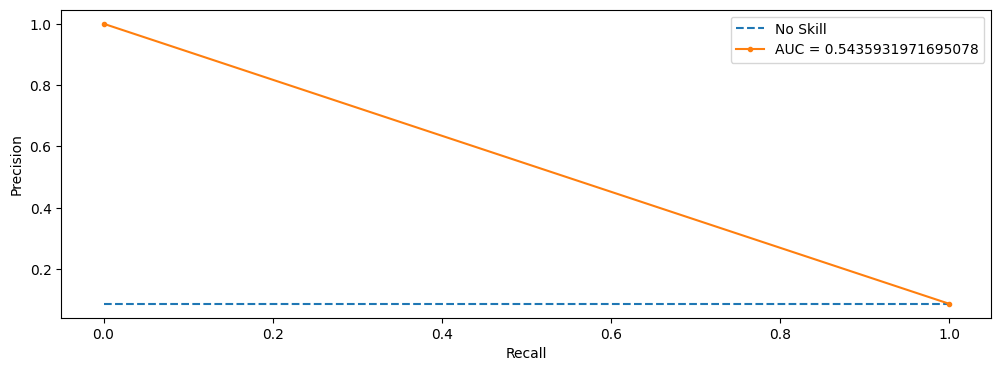

<Figure size 1200x600 with 0 Axes>

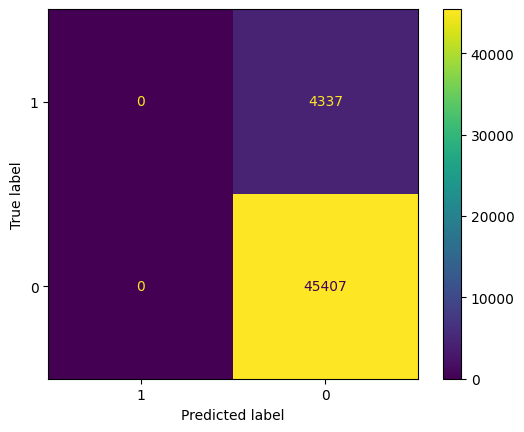

In [69]:
evaluate_model(Y_test,Y_pred_xgb_tuned_proba,Y_pred_xgb_tuned_labels)

<h4> Implementing Precision-Recall AUC score tuning </h4>

In [70]:
precision_xgb,recall_xgb,f2_score_xgb,thresholds_xgb = get_thresholding_metrics(xgb_clf_tuned,Y_pred_xgb_tuned_proba)

In [71]:
ix = np.argmax(f2_score_xgb)
best_threshold = thresholds_xgb[ix]
best_f2_score = f2_score_xgb[ix]
print('Best Threshold=%f, F2-score=%.3f' % (best_threshold, best_f2_score))

Best Threshold=0.087193, F2-score=0.323


In [72]:
Y_pred_optimal_xgb = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_xgb_tuned_proba))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00     45407
          1       0.09      1.00      0.00      0.16      0.00      0.00      4337

avg / total       0.01      0.09      0.91      0.01      0.00      0.00     49744

Weighted Recall :0.08718639433901576


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1200x600 with 0 Axes>

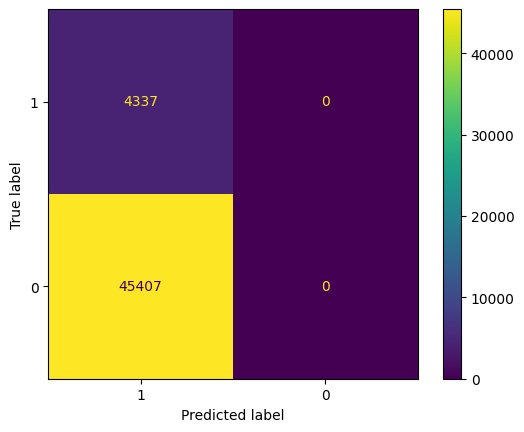

In [73]:
evaluate_model(Y_test,Y_pred_xgb_tuned_proba,Y_pred_optimal_xgb,True)

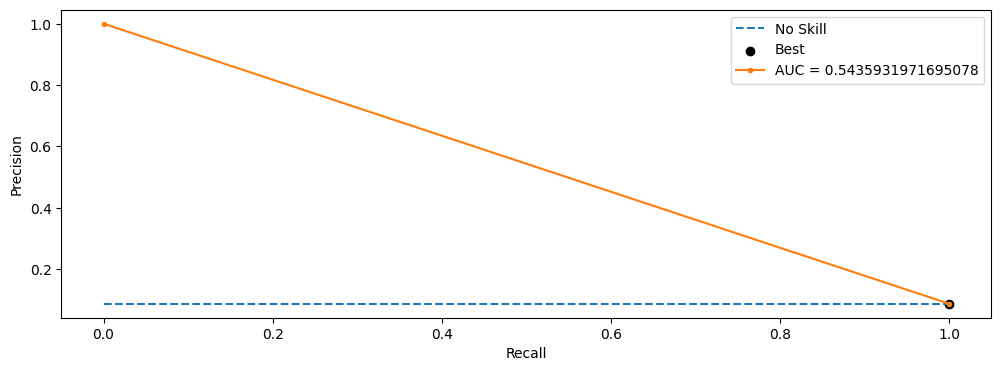

In [74]:
plot_precision_recall_curve(Y_test,Y_pred_xgb_tuned_proba,True,ix,precision_xgb,recall_xgb)

<h4> Direct optimal threshold computation </h4>

In [75]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_xgb_tuned_proba)

In [76]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_xgb_tuned_proba))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00     45407
          1       0.09      1.00      0.00      0.16      0.00      0.00      4337

avg / total       0.01      0.09      0.91      0.01      0.00      0.00     49744

Weighted Recall :0.08718639433901576


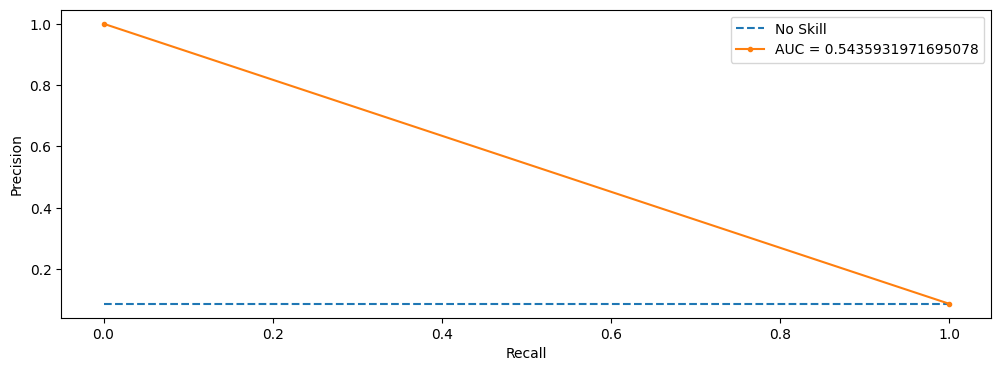

<Figure size 1200x600 with 0 Axes>

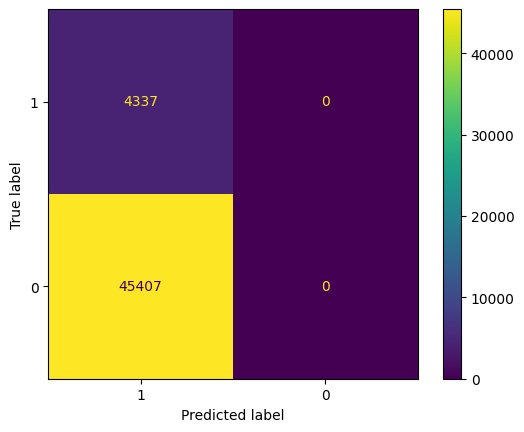

In [77]:
evaluate_model(Y_test,Y_pred_xgb_tuned_proba,Y_pred_best_threshold)

<h3><b><u>Summary so far</u></b></h3>
<p>Three models have been built, LogisticRegression, HistGradientBoost and XGBoost. For each classifier, a baseline model, tuned model and thresholding has been performed. Also, calibrated classifiers have been built with both the boosting models.<br> Now it is time to try out sampling techniques starting with oversampling. </p>

<h1> Sampling Techniques - Applied only after splitting the data into train and test sets </h1>
<p> There are two main methods to perform sampling - Undersampling and Oversampling.<br>
    <b><u>Undersampling:</u></b>  Here, records of the majority class are randomly selected to match those of the minority class. <br>
    <b>Techniques -</b> RandomUnderSampler, TomekLinks, NearMiss<br>
    <b>Cons - Loss of information.</b><br><br>
    <b><u>Oversampling:</u></b>  Here, records of the minority class are duplicated/synthetically generated to match those of the majority class. <br>
    <b>Techniques -</b> RandomOverSampler, SMOTE<br>
    <b>Cons - Overfitting.</b><br>
    

<h4> Method 1 - Random Over Sampler </h4>

In [ ]:
random_over_sampler = over_sampling.RandomOverSampler()

In [ ]:
X_train_ros, Y_train_ros = random_over_sampler.fit_resample(X_train,Y_train)

In [ ]:
Y_train_ros.value_counts()

In [ ]:
logit_clf_ros = LogisticRegression()

In [ ]:
logit_clf_ros, Y_pred_logit_ros = build_model(logit_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_ros)

In [ ]:
hgb_clf_ros = HistGradientBoostingClassifier(**best_params_hgb)

In [ ]:
hgb_clf_ros, Y_pred_clf_ros = build_model(hgb_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_clf_ros)

In [ ]:
xgb_clf_ros = XGBClassifier()

In [ ]:
xgb_clf_ros, Y_pred_xgb_ros = build_model(xgb_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_xgb_ros)

<h4> Method 2 - SMOTE </h4>

In [ ]:
smote = over_sampling.SMOTE()

In [ ]:
X_train_smote, Y_train_smote = smote.fit_resample(X_train,Y_train)

In [ ]:
logit_clf_smote = LogisticRegression()

In [ ]:
logit_clf_smote, Y_pred_logit_smote = build_model(logit_clf_smote,X_train_smote,Y_train_smote,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_smote)

In [ ]:
hgb_clf_smote = HistGradientBoostingClassifier()

In [ ]:
hgb_clf_smote,Y_pred_hgb_smote = build_model(hgb_clf_smote,X_train_smote,Y_train_smote,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_hgb_smote)

In [ ]:
xbg_smote = XGBClassifier()

In [ ]:
xbg_smote, Y_pred_xgb_smote = build_model(xbg_smote,X_train_smote,Y_train_smote,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_xgb_smote)

<h4> Method 3 - ADASYN </h4>

In [ ]:
adasyn = over_sampling.ADASYN()

In [ ]:
X_train_adasyn, Y_train_adasyn = smote.fit_resample(X_train,Y_train)

In [ ]:
logit_clf_adasyn = LogisticRegression()

In [ ]:
logit_clf_adasyn, Y_pred_logit_adasyn = build_model(logit_clf_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_adasyn)

In [ ]:
hgb_clf_adasyn = HistGradientBoostingClassifier()

In [ ]:
hgb_clf_adasyn, Y_pred_hgb_adasyn = build_model(hgb_clf_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_hgb_adasyn)

In [ ]:
xbg_adasyn = XGBClassifier()

In [ ]:
xbg_adasyn, Y_pred_xbg_adasyn = build_model(xbg_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_xbg_adasyn)

<h4> Undersampling methods </h4>

In [ ]:
random_under_sampler = under_sampling.RandomUnderSampler()

In [ ]:
X_train_under_sampler, Y_train_under_sampler = random_under_sampler.fit_resample(X_train,Y_train)

In [ ]:
logit_clf_undersampling = LogisticRegression()

In [ ]:
logit_clf_undersampling, Y_pred_logit_undersampling = build_model(logit_clf_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_undersampling)

In [ ]:
hgb_clf_undersampling = HistGradientBoostingClassifier()

In [ ]:
hgb_clf_undersampling, Y_pred_hgb_undersampling = build_model(hgb_clf_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_hgb_undersampling)

In [ ]:
xbg_undersampling = XGBClassifier()

In [ ]:
xbg_undersampling, Y_pred_xgb_undersampling = build_model(xbg_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_logit_undersampling)